In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [389]:
df = pd.read_csv('../Data/BTC.csv', parse_dates= True, index_col=0)
result_df = pd.DataFrame(index=df.index)
result_df['close'] = df['close']
result_df.head(3)

,close
timestamp,
2018-01-01 00:00:00+00:00,13444.88
2018-01-02 00:00:00+00:00,14754.13
2018-01-03 00:00:00+00:00,15156.62


### Chaikin Oscillator

In [390]:
def chaikin_oscillator(df: pd.DataFrame, result_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the Chaikin Oscillator for a given DataFrame of financial data.

    Args:
        df (pd.DataFrame): DataFrame containing financial data, including columns 'close', 'high', 'low', and 'volume'.
        result_df (pd.DataFrame): DataFrame to store the results of the Chaikin Oscillator calculation.

    Returns:
        pd.DataFrame: The result DataFrame, shifted by one row.
    """
    # calculate the Chaikin Oscillator
    adl = ((2 * df['close'] - df['high'] - df['low']) / (df['high'] - df['low'])) * df['volume']
    adl_3_ema = adl.ewm(span=3).mean()
    adl_10_ema = adl.ewm(span=10).mean()
    chaikin_oscillator = adl_3_ema - adl_10_ema
    # Trading signals -> 1 indicates Buy, 0 indicates Hold and -1 indicates Sell
    result_df['Chaikin_oscillator'] = chaikin_oscillator
    return result_df

result_df = chaikin_oscillator(df, result_df)
print(len(result_df.index))

1920


### Commodity Channel Index (CCI) 

In [391]:
def commodity_channel_index(df: pd.DataFrame, result_df: pd.DataFrame, period: int = 20) -> pd.DataFrame:
    """
    Calculates the Commodity Channel Index (CCI) for a given DataFrame of OHLC (open-high-low-close) prices.

    Args:
        df (pd.DataFrame): DataFrame of OHLC prices.
        result_df (pd.DataFrame): DataFrame to store the results.
        period (int, optional): The number of periods to use in the calculation. Defaults to 20.

    Returns:
        pd.DataFrame: The result DataFrame with the trading signals based on CCI values.
    """
    
    typical_price = (df['low'] + df['high'] + df['close']) / 3
    moving_average = typical_price.rolling(window=period).mean()
    mean_deviation = typical_price.rolling(window=period).apply(lambda x: np.fabs(x - x.mean()).mean())
    cci = (typical_price - moving_average) / (0.015 * mean_deviation)
    result_df['CCI'] = cci

    return result_df
result_df = commodity_channel_index(df,result_df)
print(len(result_df.index))

1920


### Williams Percent Range

In [392]:
def williams_r(df: pd.DataFrame,result_df, period: int = 14) -> pd.DataFrame:
    """
    Calculates the Williams %R indicator for a given DataFrame of OHLC (open-high-low-close) prices.

    Args:
        df (pd.DataFrame): DataFrame of OHLC prices.
        result_df (pd.DataFrame): DataFrame to store the results.
        period (int, optional): The number of periods to use in the calculation. Defaults to 14.

    Returns:
        pd.DataFrame: The result DataFrame with the  trading signals based on Williams %R values.
    """
    highest_high = df['high'].rolling(window = period).max()
    lowest_low = df['low'].rolling(window = period).min()
    wpr = -100 * (highest_high - df['close']) / (highest_high - lowest_low)

    result_df['williams_percentage'] = wpr    
    return result_df
result_df = williams_r(df,result_df)
print(len(result_df.index))

1920


### Parabolic SAR 

In [393]:
def parabolic_sar(df: pd.DataFrame, result_df: pd.DataFrame, af_start: float = 0.02, af_step: float = 0.02, af_max: float = 0.2):
    """
    Calculates the Parabolic SAR (Stop and Reverse) indicator for a given DataFrame of OHLC (open-high-low-close) prices.

    Args:
        df (pd.DataFrame): DataFrame of OHLC prices.
        result_df (pd.DataFrame): DataFrame to store the results.
        af_start (float, optional): Acceleration factor starting value. Defaults to 0.02.
        af_step (float, optional): Acceleration factor step. Defaults to 0.02.
        af_max (float, optional): Acceleration factor maximum value. Defaults to 0.2.

    Returns:
        pd.DataFrame: The result DataFrame with the trading signals based on PSAR values.
    """
    
    psar = df['high'].copy()
    psar[0] = df['low'][0]
    psar[1] = max(df['high'][0], df['high'][1])
    af = af_start
    trend = True
    af_list = []

    for i in range(2, len(df)):
        if trend:
            psar[i] = psar[i - 1] + af * (df['high'][i - 1] - psar[i - 1])
            if df['low'][i] < psar[i]:
                trend = False
                psar[i] = psar[i - 1]
                af_list.append(af)
                af = af_start
        else:
            psar[i] = psar[i - 1] + af * (df['low'][i - 1] - psar[i - 1])
            if df['high'][i] > psar[i]:
                trend = True
                psar[i] = psar[i - 1]
                af_list.append(af)
                af = af_start
        if trend:
            if df['high'][i] > df['high'][i - 1]:
                af = min(af + af_step, af_max)
        else:
            if df['low'][i] < df['low'][i - 1]:
                af = min(af + af_step, af_max)
        af_list.append(af)
    
    result_df['PSAR'] = psar
    
    return result_df

result_df = parabolic_sar(df,result_df)
print(len(result_df.index))

1920


### Money Flow Index (MFI)

In [394]:
# def money_flow_index(df: pd.DataFrame, result_df: pd.DataFrame, n: int = 14) -> pd.DataFrame:
#     """
#     Calculates the Money Flow Index (MFI) for a given DataFrame of financial data.

#     Args:
#         df (pd.DataFrame): DataFrame containing financial data, including columns 'high', 'low', 'close', and 'volume'.
#         result_df (pd.DataFrame): DataFrame to store the results of the MFI calculation.
#         n (int, optional): The number of periods to use in the MFI calculation. Default is 14.

#     Returns:
#         pd.DataFrame: The result DataFrame.
#     """
#     typical_price = (df['high'] + df['low'] + df['close']) / 3
#     raw_money_flow = typical_price * df['volume']
#     positive_flow = np.where(typical_price > typical_price.shift(1), raw_money_flow, 0)
#     negative_flow = np.where(typical_price < typical_price.shift(1), raw_money_flow, 0)
#     positive_mf = pd.Series(positive_flow).rolling(n).sum()
#     negative_mf = pd.Series(negative_flow).rolling(n).sum()
#     mfi = 100 - (100 / (1 + (positive_mf / negative_mf)))
#     mfi_signal = pd.Series(mfi).rolling(3).mean()
#     result_df['MFI'] = np.where(mfi > mfi_signal, 1, 0)
#     result_df['MFI'] = np.where(mfi < mfi_signal, -1, result_df['MFI'])
#     return result_df

# result_df = money_flow_index(df,result_df)
# print(len(result_df.index))
# result_df.MFI.value_counts()

### Keltner Channels

In [395]:
def keltner_channels(df: pd.DataFrame, result_df: pd.DataFrame, n: int = 10, m: int = 1) -> pd.DataFrame:
    """
    Calculates the Keltner Channels for a given DataFrame.

    Args:
        df (pandas.DataFrame): Input DataFrame containing 'open', 'high', 'low', and 'close' columns.
        result_df (pandas.DataFrame): DataFrame to store the results.
        n (int): Number of periods for calculating the EMA.
        m (int): Multiplier for calculating the upper and lower bands.
        
    Returns:
    pandas.DataFrame: DataFrame containing the trading signals.
    """
    
    middle_line = df['close'].ewm(span=n).mean()
    
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift())
    tr3 = abs(df['low'] - df['close'].shift())
    true_range = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)
    
    upper_band = middle_line + m * true_range.ewm(span=n).mean()
    lower_band = middle_line - m * true_range.ewm(span=n).mean()

    # Generate signals
    result_df['Keltner_channels_upperband'] = upper_band
    result_df['Keltner_channels_lowerband'] = lower_band
    return result_df
result_df = keltner_channels(df,result_df)
print(len(result_df.index))


1920


### Trix Indicator

In [396]:
def trix(df: pd.DataFrame, result_df: pd.DataFrame, n: int=15, m: int=9) -> pd.DataFrame:
    """
    Calculates the TRIX indicator and trading signals for a given DataFrame.

    Args:
        df (pandas.DataFrame): Input DataFrame containing 'open', 'high', 'low', and 'close' columns.
        result_df (pandas.DataFrame, optional): DataFrame to store the results. If not provided, a new DataFrame will be created.
        n (int, optional): Number of periods for calculating the TRIX.
        m (int, optional): Number of periods for calculating the signal line.

    Returns:
    pandas.DataFrame: DataFrame containing the trading signals.
    """

    ema = df['close'].ewm(span=n, min_periods=n).mean()
    ema_ema = ema.ewm(span=n, min_periods=n).mean()
    trix = (ema_ema - ema_ema.shift(1)) / ema_ema.shift(1) * 100
    trix_signal = trix.ewm(span=m, min_periods=m).mean()

    # Trading signals
    result_df['TRIX'] = trix_signal    
    return result_df


result_df = trix(df,result_df)
print(len(result_df.index))

1920


### Ultimate Oscillator

In [397]:
def ultimate_oscillator(df, result_df, short_period=7, medium_period=14, long_period=28, buy_thresh=30, sell_thresh=70):
    """
    This function calculates the Ultimate Oscillator for a given DataFrame and generates buy/sell signals based on the oscillator values.

    Args:
    df (pandas.DataFrame): Input DataFrame containing 'open', 'high', 'low', and 'close' columns.
    result_df (pandas.DataFrame): DataFrame to store the results.
    short_period (int): Number of periods for calculating the short-term average.
    medium_period (int): Number of periods for calculating the medium-term average.
    long_period (int): Number of periods for calculating the long-term average.
    buy_thresh (float): Buy threshold for the oscillator.
    sell_thresh (float): Sell threshold for the oscillator.

    Returns:
    pandas.DataFrame: DataFrame containing the Ultimate Oscillator and signals.
    """

    # Calculate buying pressure, true range, and average true range
    bp = df['close'] - pd.concat([df['low'], df['close'].shift(1)], axis=1).min(axis=1)
    tr = pd.concat([df['high'] - df['low'], abs(df['high'] - df['close'].shift(1)), abs(df['low'] - df['close'].shift(1))], axis=1).max(axis=1)
    atr_short = tr.rolling(short_period).sum()
    atr_medium = tr.rolling(medium_period).sum()
    atr_long = tr.rolling(long_period).sum()

    # Calculate the buying pressure for each period
    bp_short = bp.rolling(short_period).sum()
    bp_medium = bp.rolling(medium_period).sum()
    bp_long = bp.rolling(long_period).sum()

    # Calculate the raw Ultimate Oscillator values
    raw_uo_short = bp_short / atr_short
    raw_uo_medium = bp_medium / atr_medium
    raw_uo_long = bp_long / atr_long

    # Calculate the weighted Ultimate Oscillator values
    total_period = short_period + medium_period + long_period
    wuo_short = (4 * raw_uo_short + 2 * raw_uo_medium + raw_uo_long) / 7
    wuo_medium = (2 * raw_uo_short + 4 * raw_uo_medium + raw_uo_long) / 7
    wuo_long = (raw_uo_short + 2 * raw_uo_medium + 4 * raw_uo_long) / 7

    # Calculate the Ultimate Oscillator
    uo = (wuo_short * short_period + wuo_medium * medium_period + wuo_long * long_period) / total_period

    # Trading signals
    result_df['Ultimate_oscillator'] = uo

    return result_df


result_df = ultimate_oscillator(df,result_df)
print(len(result_df.index))


1920


### AD Indicator

In [398]:
def ad_indicator(df, result_df, window_short = 3, window_long = 10):
    """This function calculates the Accumulation/Distribution (A/D) indicator for a given DataFrame.

    Args:
    df (pandas.DataFrame): Input DataFrame containing 'open', 'high', 'low', 'close', and 'volume' columns.
    result_df (pandas.DataFrame): DataFrame to store the results.

    Returns:
    pandas.DataFrame: DataFrame containing the A/D indicator and signals.
    """
    ad = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low']) * df['volume']
    ad = ad.cumsum()

    # Trading signals
    result_df['ad_indicator'] = ad
    return result_df


result_df = ad_indicator(df, result_df)
print(len(result_df.index))


1920


### Donchain Channels

In [399]:
def donchian_channel(df, result_df, n = 20):
    """
    This function calculates the Donchian Channel for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): Input DataFrame containing 'open', 'high', 'low', and 'close' columns.
    result_df (pandas.DataFrame): DataFrame to store the results.
    n (int): Number of periods for calculating the Donchian Channel.

    Returns:
    pandas.DataFrame: DataFrame containing the Donchian Channel signals.
    """
    upper_band = df['high'].rolling(n).max()
    lower_band = df['low'].rolling(n).min()
    middle_band = (upper_band + lower_band) / 2

    # Trading signals
    result_df['Donchian_channel_upper'] = upper_band
    result_df['Donchian_channel_lower'] = lower_band
    result_df['Donchian_channel_middle'] = middle_band
    return result_df

result_df = donchian_channel(df, result_df)
print(len(result_df.index))


1920


### SMA Crossover

In [400]:
def sma_crossover(df,result_df, short_period = 30, long_period = 60):
    sma_short = df['close'].rolling(window=short_period).mean()
    sma_long = df['close'].rolling(window=long_period).mean()
    result_df['SMA_short'] = sma_short
    result_df['SMA_long'] = sma_long
    return result_df

result_df = sma_crossover(df, result_df)
print(len(result_df.index))

1920


### EMA Crossover

In [401]:
def ema_crossover(df,result_df, short_period = 30, long_period = 60):
    ema_short = df['close'].ewm(span=short_period, adjust=False).mean()
    ema_long = df['close'].ewm(span=long_period, adjust=False).mean()
    result_df['EMA_short'] = ema_short
    result_df['EMA_long'] = ema_long
    return result_df
result_df = ema_crossover(df, result_df)
print(len(result_df.index))

1920


## RSI

In [402]:
def rsi_strategy(df,result_df, rsi_period=14, rsi_upper=70, rsi_lower=30):
    delta = df['close'].diff()
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)
    avg_gain = up.rolling(rsi_period).mean()
    avg_loss = down.rolling(rsi_period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    result_df['RSI'] = rsi
    return result_df
result_df = rsi_strategy(df, result_df)
print(len(result_df.index))

1920


### Ichimoku Cloud

In [403]:
# def ichimoku_cloud_signals(df, result_df):
#     period9_high = df['high'].rolling(window=9).max()
#     period9_low = df['low'].rolling(window=9).min()
#     conversion_line = (period9_high + period9_low) / 2
#     period26_high = df['high'].rolling(window=26).max()
#     period26_low = df['low'].rolling(window=26).min()
#     base_line = (period26_high + period26_low) / 2
#     spanA = ((conversion_line + base_line) / 2).shift(26)
#     period52_high = df['high'].rolling(window=52).max()
#     period52_low = df['low'].rolling(window=52).min()
#     spanB = ((period52_high + period52_low) / 2).shift(26)
#     chikou_span = df['close'].shift(-26)
#     buy_signal = (spanA > spanB) & (df['close'] > spanA) & (df['close'] > spanB) & (df['close'] > chikou_span)
#     sell_signal = (spanA < spanB) & (df['close'] < spanA) & (df['close'] < spanB) & (df['close'] < chikou_span)
#     result_df['ichimoku_cloud'] = 0
#     result_df.loc[buy_signal, 'ichimoku_cloud'] = 1
#     result_df.loc[sell_signal, 'ichimoku_cloud'] = -1
#     return result_df
# result_df = ichimoku_cloud_signals(df, result_df)
# print(len(result_df.index))
# result_df.ichimoku_cloud.value_counts()

### MACD Strategy

In [404]:
def macd_strategy(data,result_df, fast_period=12, slow_period=26, signal_period=9):

    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    histogram = macd - signal
    # Generate trading signals based on the MACD and signal line
    result_df['MACD'] = macd
    result_df['MACD_signal'] = signal
    result_df['MACD_histogram'] = histogram
    return result_df
result_df = macd_strategy(df, result_df)
print(len(result_df.index))

1920


### Stochastic Oscillator Strategy

In [405]:
def stochastic_oscillator_strategy(df, result_df, period=14, oversold=20, overbought=80):
    highs = df['high']
    lows = df['low']
    closes = df['close']

    # Calculate the stochastic oscillator
    stochastic_oscillator = 100 * ((closes - lows.rolling(period).min()) / (highs.rolling(period).max() - lows.rolling(period).min()))
    result_df['Stochastic_oscillator'] = stochastic_oscillator
    return result_df
result_df = stochastic_oscillator_strategy(df, result_df)
print(len(result_df.index))

1920


### Volume Weighted Average Price (VWAP)

In [406]:
def vwap_signals(df, result_df):
    df['TP'] = (df['high'] + df['low'] + df['close']) / 3
    df['VP'] = df['TP'] * df['volume']
    df['Cumulative VP'] = df['VP'].cumsum()
    df['Cumulative Volume'] = df['volume'].cumsum()
    df['VWAP'] = df['Cumulative VP'] / df['Cumulative Volume']
    result_df['VWAP'] = df['VWAP']
    return result_df
result_df = vwap_signals(df, result_df)
print(len(result_df.index))

1920


### Bollinger Band Strategy

In [407]:
def bollinger_band_strategy(df, result_df, window_size=20, num_std=2):
    rolling_mean = df['close'].rolling(window=window_size).mean()
    rolling_std = df['close'].rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    result_df['bollinger_band_lower'] = lower_band
    result_df['bollinger_band_upper'] = upper_band
    return result_df
result_df = bollinger_band_strategy(df, result_df)
print(len(result_df.index))

1920


### Fibonacci Retracements Strategy

In [408]:
# def fibonacci_retracements_strategy(df, result_df, buy_level=0.618, sell_level=0.382):
#     close_prices = df['close']
#     high = max(close_prices)
#     low = min(close_prices)
#     diff = high - low
#     levels = [low + buy_level * diff, low + sell_level * diff]
#     signals = [0] * len(close_prices)
#     for i in range(len(close_prices)):
#         if close_prices[i] <= levels[0]:
#             signals[i] = 1
#         elif close_prices[i] >= levels[1]:
#             signals[i] = -1
#     result_df['Fibonacci_retracement'] = signals
#     return result_df
# result_df = fibonacci_retracements_strategy(df, result_df)
# print(len(result_df.index))
# result_df.Fibonacci_retracement.value_counts()

### ADX Strategy

In [409]:
def adx_strategy(df, result_df, n=14, adx_threshold=25):

    df['tr'] = np.max([df['high'] - df['low'], abs(df['high'] - df['close'].shift()), abs(df['low'] - df['close'].shift())], axis=0)
    df['up_move'] = df['high'] - df['high'].shift()
    df['down_move'] = df['low'].shift() - df['low']
    df['up_move'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['down_move'] = np.where((df['up_move'] < df['down_move']) & (df['down_move'] > 0), df['down_move'], 0)
    df['atr'] = df['tr'].rolling(window=n).mean()
    df['plus_di'] = 100 * (df['up_move'] / df['atr']).ewm(span=n, adjust=False).mean()
    df['minus_di'] = 100 * (df['down_move'] / df['atr']).ewm(span=n, adjust=False).mean()
    df['dx'] = 100 * (abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di'])).ewm(span=n, adjust=False).mean()
    df['adx'] = df['dx'].ewm(span=n, adjust=False).mean()
    result_df['ADX'] = df['adx']
    return result_df
result_df = adx_strategy(df, result_df)
print(len(result_df.index))


1920


In [410]:
result_df.columns.tolist()

['close',
 'Chaikin_oscillator',
 'CCI',
 'williams_percentage',
 'PSAR',
 'Keltner_channels_upperband',
 'Keltner_channels_lowerband',
 'TRIX',
 'Ultimate_oscillator',
 'ad_indicator',
 'Donchian_channel_upper',
 'Donchian_channel_lower',
 'Donchian_channel_middle',
 'SMA_short',
 'SMA_long',
 'EMA_short',
 'EMA_long',
 'RSI',
 'MACD',
 'MACD_signal',
 'MACD_histogram',
 'Stochastic_oscillator',
 'VWAP',
 'bollinger_band_lower',
 'bollinger_band_upper',
 'ADX']

In [411]:
result_df.head()

,close,Chaikin_oscillator,CCI,williams_percentage,PSAR,Keltner_channels_upperband,Keltner_channels_lowerband,TRIX,Ultimate_oscillator,ad_indicator,...,EMA_long,RSI,MACD,MACD_signal,MACD_histogram,Stochastic_oscillator,VWAP,bollinger_band_lower,bollinger_band_upper,ADX
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,13444.88,0.000000e+00,NaN,NaN,12877.67,14488.740000,12401.020000,NaN,NaN,9.174520e+07,...,13444.880000,NaN,0.000000,0.000000,0.000000,NaN,13414.693333,NaN,NaN,NaN
2018-01-02 00:00:00+00:00,14754.13,1.113328e+08,NaN,NaN,15306.13,15939.288000,12390.647000,NaN,NaN,1.137771e+09,...,13487.806230,NaN,104.441595,20.888319,83.553276,NaN,14009.835435,NaN,NaN,NaN
2018-01-03 00:00:00+00:00,15156.62,3.810820e+07,NaN,NaN,15306.13,15968.485581,13158.724850,NaN,NaN,1.697677e+09,...,13542.521435,NaN,217.186303,60.147916,157.038387,NaN,14373.599931,NaN,NaN,NaN
2018-01-04 00:00:00+00:00,15180.08,1.018277e+08,NaN,NaN,15306.13,16092.223913,13441.188468,NaN,NaN,2.703713e+09,...,13596.211880,NaN,304.915447,109.101422,195.814025,NaN,14524.314632,NaN,NaN,NaN
2018-01-05 00:00:00+00:00,16954.78,3.268006e+08,NaN,NaN,15306.13,16998.554688,13791.130654,NaN,NaN,4.644953e+09,...,13706.328867,NaN,511.745796,189.630297,322.115499,NaN,14999.401751,NaN,NaN,NaN


In [412]:
result_df.tail(10)

,close,Chaikin_oscillator,CCI,williams_percentage,PSAR,Keltner_channels_upperband,Keltner_channels_lowerband,TRIX,Ultimate_oscillator,ad_indicator,...,EMA_long,RSI,MACD,MACD_signal,MACD_histogram,Stochastic_oscillator,VWAP,bollinger_band_lower,bollinger_band_upper,ADX
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-26 00:00:00+00:00,27996.81,2.122983e+07,73.144834,-12.613603,26183.717665,28424.617366,25901.071153,0.845505,0.546088,1.264511e+11,...,23804.393037,75.431580,1378.091630,1153.642927,224.448702,87.386397,30781.466231,19224.358003,31050.775997,43.140661
2023-03-27 00:00:00+00:00,27145.09,-1.174160e+08,51.433919,-35.156585,26467.766792,28460.776027,25858.456398,0.848601,0.523394,1.261629e+11,...,23913.924085,64.322015,1295.766952,1182.067732,113.699220,64.843415,30779.000836,19576.029846,31193.526154,43.141603
2023-03-28 00:00:00+00:00,27274.90,8.187603e+07,43.940158,-32.521774,26467.766792,28398.116749,25963.037053,0.836641,0.541374,1.266458e+11,...,24024.120017,62.787741,1226.856200,1191.025426,35.830774,67.478226,30777.008650,20066.654413,31259.634587,42.709978
2023-03-29 00:00:00+00:00,28355.87,2.768599e+08,66.388952,-11.195803,26467.766792,28641.206431,26147.326679,0.826895,0.581968,1.275087e+11,...,24166.144606,68.930768,1245.116252,1201.843591,43.272661,88.804197,30774.936466,20936.457767,31188.480233,42.344665
2023-03-30 00:00:00+00:00,28037.46,-2.709383e+08,72.101813,-26.858872,26554.695720,28793.481626,26228.940010,0.812323,0.539191,1.264783e+11,...,24293.072980,64.686990,1219.832974,1205.441468,14.391506,73.141128,30772.632569,22068.139760,30839.773240,42.165650
2023-03-31 00:00:00+00:00,28477.29,1.718411e+08,69.580631,-26.680858,26711.787977,28937.672239,26436.050918,0.798336,0.556204,1.274664e+11,...,24430.260423,56.308845,1221.209061,1208.594986,12.614075,73.319142,30770.718162,23346.268463,30348.323537,41.991473
2023-04-01 00:00:00+00:00,28465.30,-2.493723e+07,88.350836,-27.140748,26828.108898,28950.973650,26705.818023,0.782692,0.556223,1.273159e+11,...,24562.556803,59.611177,1207.413812,1208.358751,-0.944939,72.859252,30770.053979,24367.236940,29955.810060,41.877595
2023-04-02 00:00:00+00:00,28186.76,-6.841110e+07,68.205514,-37.824444,26986.736186,28931.554805,26855.551110,0.761019,0.541949,1.272746e+11,...,24681.383137,51.071104,1160.626152,1198.812232,-38.186079,62.175556,30769.259168,24906.327768,29814.813232,41.486941
2023-04-03 00:00:00+00:00,27810.08,-1.307225e+08,37.309478,-52.272405,27110.866091,28946.628477,26810.123636,0.730018,0.543766,1.270739e+11,...,24783.963362,50.019585,1080.694098,1175.188605,-94.494507,47.727595,30767.034507,25381.791619,29644.486381,40.484451


In [413]:
result_df.describe()

,close,Chaikin_oscillator,CCI,williams_percentage,PSAR,Keltner_channels_upperband,Keltner_channels_lowerband,TRIX,Ultimate_oscillator,ad_indicator,...,EMA_long,RSI,MACD,MACD_signal,MACD_histogram,Stochastic_oscillator,VWAP,bollinger_band_lower,bollinger_band_upper,ADX
count,1920.000000,1.920000e+03,1901.000000,1907.000000,1920.000000,1920.000000,1920.000000,1883.000000,1893.000000,1.920000e+03,...,1920.000000,1907.000000,1920.000000,1920.000000,1920.000000,1907.000000,1920.000000,1901.000000,1901.000000,1905.000000
mean,20462.431656,-8.448209e+05,6.725435,-47.567931,20449.207272,21578.900413,19283.315190,0.044552,0.528897,6.046149e+10,...,20286.501530,51.463940,45.642890,43.252945,2.389945,52.432069,17574.196599,17818.871782,23087.874146,40.269868
std,16590.651528,2.711980e+08,115.476791,29.161935,16549.530336,17500.484347,15543.763630,0.691627,0.077669,5.083910e+10,...,16061.433415,18.077723,1204.032082,1143.700884,333.591192,29.161935,10320.670119,14535.671602,18758.878989,11.840296
min,3232.510000,-1.764338e+09,-475.798442,-99.917985,3430.430510,3518.481540,3212.496150,-1.871937,0.292779,9.174520e+07,...,3767.584004,5.520658,-5067.075536,-4435.845540,-1724.643375,0.082015,8323.734084,2946.784587,3674.798576,20.178059
25%,7926.205000,-9.020049e+07,-79.433065,-73.191501,7854.419545,8286.029081,7418.827061,-0.362786,0.475033,1.172624e+10,...,8067.245266,37.922523,-372.180321,-348.280553,-102.009137,26.808499,8708.165776,6755.404167,9010.687613,31.305504
50%,11477.380000,5.577014e+06,7.706848,-47.563956,11138.395371,12035.323863,10682.429749,-0.020417,0.529888,3.069683e+10,...,10920.620509,51.161128,-19.212328,-29.271917,7.620161,52.436044,10119.489291,10059.504553,12595.678943,38.170446
75%,32115.337500,9.141179e+07,96.465796,-20.097377,32440.696592,35046.049689,30287.892782,0.467587,0.579913,1.193632e+11,...,33719.234565,63.866060,391.152698,370.819834,115.341329,79.902623,30819.462804,28008.235618,38260.968461,47.090003
max,67549.140000,1.698550e+09,480.821063,-0.044053,63344.412697,67070.676122,61850.913315,2.470759,0.767811,1.354823e+11,...,58019.002190,99.454826,5249.588767,4504.527101,1303.501620,99.955947,32818.938771,58919.709812,69087.882774,100.000000


In [414]:
rolling_avg = result_df['close'].rolling(window=3).mean()
result_df['return'] = ((result_df['close'] - rolling_avg) / rolling_avg) * 100

In [415]:
result_df['target'] = result_df['return'].apply(lambda x: 1 if x > 0.7 else (-1 if x < -1 else 0))
result_df['target'].value_counts()

 1    698
 0    688
-1    534
Name: target, dtype: int64

In [416]:
#result_df.fillna(0, inplace=True)
result_df.dropna(inplace=True)

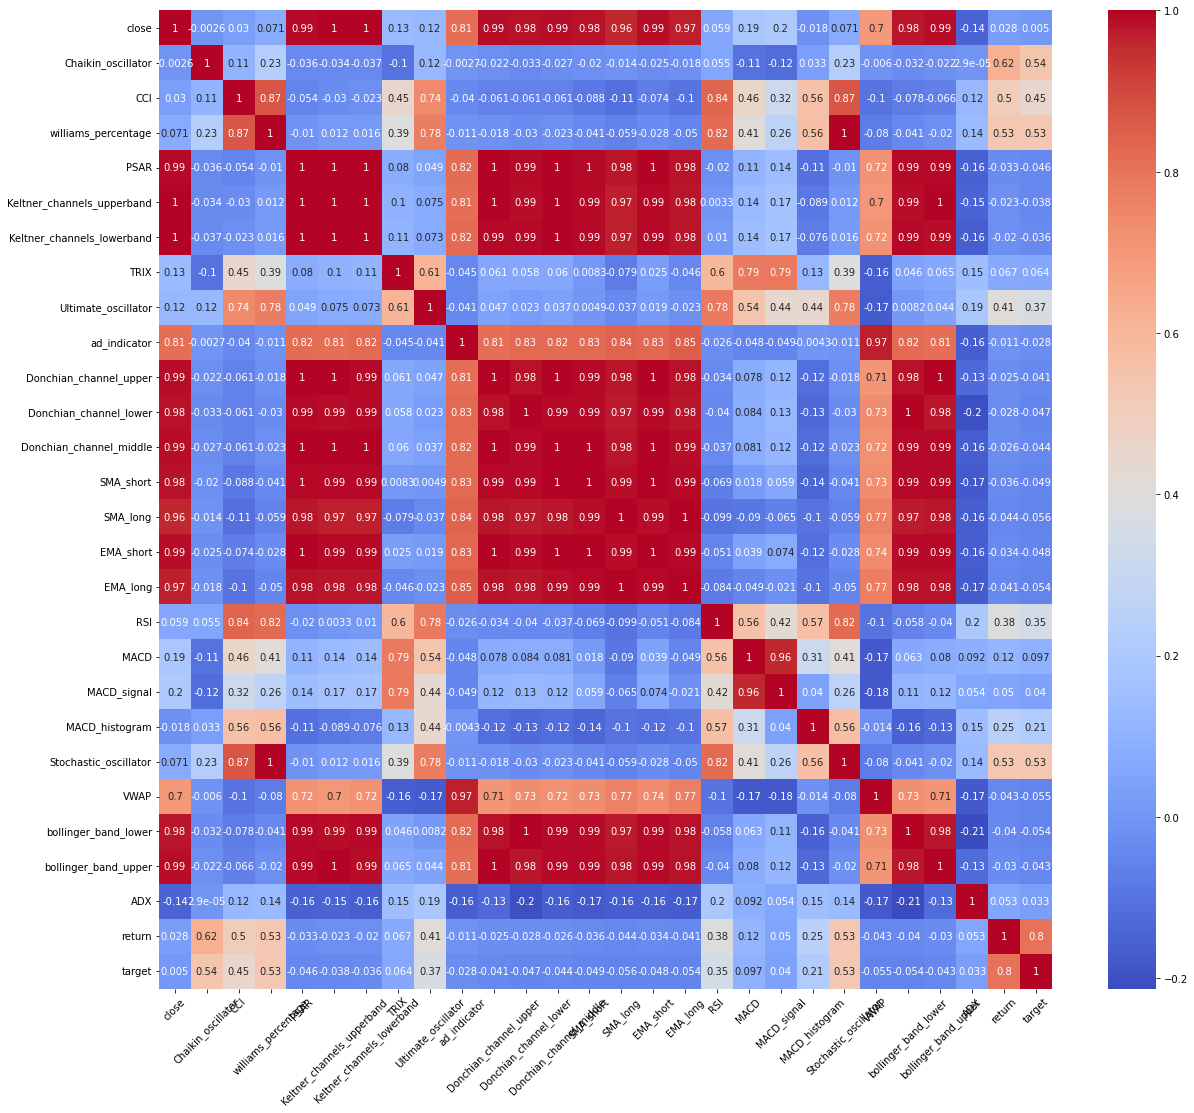

In [417]:
corr_matrix = result_df.corr()
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax = ax)
plt.xticks(rotation = 45)
plt.show()

In [418]:
result_df.to_csv('indicators.csv')

In [419]:
result_df

,close,Chaikin_oscillator,CCI,williams_percentage,PSAR,Keltner_channels_upperband,Keltner_channels_lowerband,TRIX,Ultimate_oscillator,ad_indicator,...,MACD,MACD_signal,MACD_histogram,Stochastic_oscillator,VWAP,bollinger_band_lower,bollinger_band_upper,ADX,return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00+00:00,10929.37,1.212620e+08,74.580435,-35.298590,10142.146888,11190.338986,9464.105603,0.226935,0.535553,1.005499e+10,...,96.002957,-41.915509,137.918466,64.701410,11192.822467,8174.729709,11802.987291,32.765792,2.917708,1
2018-03-02 00:00:00+00:00,11043.12,1.295615e+08,93.556571,-30.698523,10236.962199,11234.570293,9680.201991,0.275395,0.523143,1.025779e+10,...,150.337994,-3.464809,153.802802,69.301477,11191.225425,8370.026037,11855.073963,31.744213,2.545677,1
2018-03-03 00:00:00+00:00,11465.36,2.458508e+08,118.798268,-13.623074,10351.559535,11365.176210,9916.133470,0.338236,0.533494,1.085243e+10,...,224.877888,42.203731,182.674158,86.376926,11192.520685,8720.957931,11842.217069,31.114049,2.865705,1
2018-03-04 00:00:00+00:00,11504.42,2.675387e+08,113.967555,-12.043481,10516.633600,11473.362703,10122.044414,0.405838,0.569436,1.143595e+10,...,283.831277,90.529240,193.302037,87.956519,11193.814655,8899.866402,11922.623598,30.795111,1.471089,1
2018-03-05 00:00:00+00:00,11440.73,-1.678010e+08,126.973939,-14.619114,10680.338624,11515.175050,10314.060483,0.468626,0.536724,1.069981e+10,...,321.704602,136.764312,184.940289,85.380886,11196.445572,9257.730727,11854.363273,30.827109,-0.256666,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 00:00:00+00:00,28477.29,1.718411e+08,69.580631,-26.680858,26711.787977,28937.672239,26436.050918,0.798336,0.556204,1.274664e+11,...,1221.209061,1208.594986,12.614075,73.319142,30770.718162,23346.268463,30348.323537,41.991473,0.661301,0
2023-04-01 00:00:00+00:00,28465.30,-2.493723e+07,88.350836,-27.140748,26828.108898,28950.973650,26705.818023,0.782692,0.556223,1.273159e+11,...,1207.413812,1208.358751,-0.944939,72.859252,30770.053979,24367.236940,29955.810060,41.877595,0.489350,0
2023-04-02 00:00:00+00:00,28186.76,-6.841110e+07,68.205514,-37.824444,26986.736186,28931.554805,26855.551110,0.761019,0.541949,1.272746e+11,...,1160.626152,1198.812232,-38.186079,62.175556,30769.259168,24906.327768,29814.813232,41.486941,-0.668477,0
